# Libraries

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import glob as glob
from multiprocessing import Pool
from scipy.optimize import curve_fit
import os
import sqlite3
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

import pandas as pd
import ast

In [53]:
def calculate_specific_heat(energies, kB, T, N, dimensions):
    avg_energy = np.mean(energies)
    energy_sq = np.mean(np.array(energies)**2)
    C = (energy_sq - avg_energy**2) / (kB * T**2 * N**dimensions)  # Specific heat
    return C

def initialize_lattice(N, N_alloys):
    radius = int(np.ceil(0.5+np.sqrt(9+12*(N-1))/6)-1) #N1 = 1+ 6*n*(n-1)/2
    # -1 to offset the n meaning here
    points = generate_hexagonal_grid(radius,N_alloys)
    
    return points,radius

########################################################################
mass_gain_df = pd.read_excel("Final_Mass_Gains.xlsx")
##############################################################
diffusion_values = {}
for index, row in mass_gain_df.iterrows():
    # tuple key is sorted so that (a1, a2) and (a2, a1) commute
    key = tuple(sorted((row['Left'], row['Right'])))
    mean = ast.literal_eval(row['Mass_Gain(mg/cm2)'])
    sigma = ast.literal_eval(row['Mass_Gain_Std.Deviation'])
    diffusion_values[key] = (mean, sigma)


def diffusion_couple(a1, a2):
    key = tuple(sorted((a1, a2)))
    # Handles the case where the key doesn't exist:
    return diffusion_values.get(key, ([10e5], [0]))
###################################################################
def obj_fun(a1,a2):
    if a1==a2:
        return 10e4
    #if ((a1>0 and a1<16) and (a2==0 or a2>15)) or ((a2>0 and a2<16) and (a1==0 or a1>15)):
    #    #print(a1,a2)
    #    return 10e5
    else:
        beta = 1
        mean,sigma  = diffusion_couple(a1,a2)
        oxidations = np.min(np.array(mean) - beta*np.array(sigma))
        if oxidations<0:
            print(oxidations, mean, a1,a2)
        return oxidations

def calculate_energy(lattice):
    """Calculate the total energy of the lattice."""
    energy = 0
    for point in lattice:
        for neighbor in point.neighbors:
            energy+= obj_fun(point.alloy,neighbor.alloy)
            #print("Energy calculation:", energy, point.alloy, neighbor.alloy)

    return energy/2

def calculate_delta_energy(point1, point2):
    """Calculate the energy difference for a proposed spin swap"""
    energy_before = 0
    energy_after = 0

    # Set for unique neighbors to handle potential overlap or double counting
    point1_neighbors = set(point1.neighbors) - {point2}
    point2_neighbors = set(point2.neighbors) - {point1}

    # Calculate initial energy for point1 and point2 with their respective neighbors
    for neighbor in point1_neighbors:
        energy_before += obj_fun(point1.alloy, neighbor.alloy)
    energy_before += obj_fun(point1.alloy, point2.alloy)  # Include their mutual interaction if they are neighbors

    for neighbor in point2_neighbors:
        energy_before += obj_fun(point2.alloy, neighbor.alloy)

    # Calculate energy after swapping the alloys
    for neighbor in point1_neighbors:
        energy_after += obj_fun(point2.alloy, neighbor.alloy)
    energy_after += obj_fun(point2.alloy, point1.alloy)  # Include their mutual interaction if they are neighbors

    for neighbor in point2_neighbors:
        energy_after += obj_fun(point1.alloy, neighbor.alloy)

    deltaE = energy_after-energy_before

    return deltaE

def select_points_with_nonzero_alloy(lattice):
    while True:
        point1, point2 = random.sample(lattice, 2)
        #if point1.alloy != 0 and point2.alloy != 0:
        #if (point1.alloy> 0 and point1.alloy<16) and (point2.alloy > 0 and point2.alloy<16):
        if (not point1.fixed and not point2.fixed):
            return [point1, point2]
        
def metropolis_step(lattice, kB, T, current_energy=None):
    #[point1,point2] = random.sample(lattice, 2)
    [point1,point2] = select_points_with_nonzero_alloy(lattice)

    deltaE = calculate_delta_energy(point1,point2)

    # Update proposal
    if deltaE < 0 :#or np.random.rand() < np.exp(-deltaE / (kB * T)):
        print("Swapping: ", (point1.alloy, point2.alloy, deltaE))
        '''
        temp = point1.alloy
        point1.alloy = point2.alloy
        point2.alloy = temp
        '''
        point1.alloy, point2.alloy = point2.alloy, point1.alloy
        if current_energy is not None:
            current_energy += deltaE
        else:
            print("Current energy is None")

    return deltaE, current_energy

######################################################################################
def save_simulation_data_sqlite(db_file, steps, lattices, energies, overwrite=False):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Create tables if they don't exist
    c.execute('''CREATE TABLE IF NOT EXISTS simulation_steps
                 (step INTEGER PRIMARY KEY, energy REAL)''')
    c.execute('''CREATE TABLE IF NOT EXISTS lattices
                 (step INTEGER, lattice BLOB,
                  FOREIGN KEY(step) REFERENCES simulation_steps(step))''')

    if overwrite:
        # Clear existing data
        c.execute('DELETE FROM simulation_steps')
        c.execute('DELETE FROM lattices')

    # Insert or update rows in the database
    for step, energy, lattice in zip(steps, energies, lattices):
        # Serialize the lattice with Pickle
        pickled_lattice = pickle.dumps(lattice)

        # Insert or replace step data
        c.execute('''INSERT OR REPLACE INTO simulation_steps (step, energy)
                     VALUES (?, ?)''', (step, energy))

        # Insert or replace lattice data
        c.execute('''INSERT OR REPLACE INTO lattices (step, lattice)
                     VALUES (?, ?)''', (step, pickled_lattice))

    # Commit changes and close the connection
    conn.commit()
    conn.close()

def load_simulation_data_sqlite(db_file='simulation_state.sqlite', steps_to_load=None):
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Prepare the query
    query = '''SELECT s.step, s.energy, l.lattice
               FROM simulation_steps s
               LEFT JOIN lattices l ON s.step = l.step'''

    if steps_to_load:
        query += f" WHERE s.step IN ({','.join('?' for _ in steps_to_load)})"
        c.execute(query, steps_to_load)
    else:
        c.execute(query)

    loaded_steps, energies, lattices = [], [], []

    for step, energy, pickled_lattice in c.fetchall():
        # Unpickle the lattice
        lattice = pickle.loads(pickled_lattice) if pickled_lattice else None

        loaded_steps.append(step)
        energies.append(energy)
        lattices.append(lattice)

    conn.close()

    return np.array(loaded_steps), np.array(lattices), np.array(energies)


def load_last_simulation_state(simulation_state_file):
    """Loads the last simulation state from the SQLite database."""
    if not os.path.exists(simulation_state_file):
        return None, None, None, 0  # Indicates that there is no previous state

    with sqlite3.connect(simulation_state_file) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT MAX(step) FROM simulation_steps")
        last_step = cursor.fetchone()[0]
        if last_step is None:
            return None, None, None, 0

        cursor.execute("SELECT energy FROM simulation_steps WHERE step = ?", (last_step,))
        step_data = cursor.fetchone()
        energy = step_data[0] if step_data else (None)

        cursor.execute("SELECT lattice FROM lattices WHERE step = ?", (last_step,))
        lattice_data = cursor.fetchone()
        lattice = pickle.loads(lattice_data[0]) if lattice_data and lattice_data[0] else None

        return last_step, lattice, energy, last_step
    

def run_simulation_init(N, T, kB, N_alloys, steps=10000, save_interval=100, chunk_size=100, simulation_state_file='simulation_state.sqlite'):
    T +=(10**-6)
    
    # Load last simulation state if exists
    last_step, last_lattice, last_energy, completed_steps = load_last_simulation_state(simulation_state_file)
    
    if completed_steps >= steps:
        print(f"Simulation already completed up to {completed_steps} steps.")
        return True
    
    # Initialize simulation from the last saved state or start a new simulation
    if last_step is not None and last_lattice is not None:
        lattice = last_lattice
        current_energy = last_energy
        start_step = last_step + 1
        print(f"Resuming from step {last_step}.")
    else:
        lattice,radius = initialize_lattice(N, N_alloys)
        current_energy = calculate_energy(lattice)
        start_step = 1
    
    accumulated_steps = []
    accumulated_lattices = []
    accumulated_energies = []

    for step in range(start_step, steps + 1):
        deltaE, current_energy = metropolis_step(lattice, kB, T, current_energy)
        
        if step % save_interval == 0 or step == steps:
            accumulated_steps.append(step)
            accumulated_lattices.append(lattice.copy())
            accumulated_energies.append(current_energy)
            
            if len(accumulated_steps) == chunk_size or step == steps:
                save_simulation_data_sqlite(simulation_state_file, accumulated_steps, accumulated_lattices, accumulated_energies, overwrite=False)
                print(f"Saved step {step}.")
                
                # Clear accumulated data after saving
                accumulated_steps = []
                accumulated_lattices = []
                accumulated_energies = []

    return radius

def run_simulation(initial_lattice, radius, T, kB, steps=10000, save_interval=100, chunk_size=100, simulation_state_file='simulation_state.sqlite'):
    T +=(10**-6)
    
    # Load last simulation state if exists
    last_step, last_lattice, last_energy, completed_steps = load_last_simulation_state(simulation_state_file)
    
    if completed_steps >= steps:
        print(f"Simulation already completed up to {completed_steps} steps.")
        return True
    
    # Initialize simulation from the last saved state or start a new simulation
    if last_step is not None and last_lattice is not None:
        lattice = last_lattice
        current_energy = last_energy
        start_step = last_step + 1
        print(f"Resuming from step {last_step}.")
    else:
        lattice = initial_lattice
        current_energy = calculate_energy(lattice)
        start_step = 1
    
    accumulated_steps = []
    accumulated_lattices = []
    accumulated_energies = []

    for step in range(start_step, steps + 1):
        deltaE, current_energy = metropolis_step(lattice, kB, T, current_energy)
        
        if step % save_interval == 0 or step == steps:
            accumulated_steps.append(step)
            accumulated_lattices.append(lattice.copy())
            accumulated_energies.append(current_energy)
            
            if len(accumulated_steps) == chunk_size or step == steps:
                save_simulation_data_sqlite(simulation_state_file, accumulated_steps, accumulated_lattices, accumulated_energies, overwrite=False)
                print(f"Saved step {step}.")
                
                # Clear accumulated data after saving
                accumulated_steps = []
                accumulated_lattices = []
                accumulated_energies = []

    return radius
########################################################################################
hex_directions = [
    (1, 0), (1, -1), (0, -1),
    (-1, 0), (-1, 1), (0, 1)
]
class LatticePoint:
    def __init__(self, x, y, q, r, alloy, fixed=False):
        self.x = x
        self.y = y
        self.q = q  # Adding axial coordinates
        self.r = r
        self.fixed = fixed
        self.alloy = alloy
        self.neighbors = []  # Initialize an empty list for neighbors

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

def hex_to_pixel(q, r, size=1):
    """
    Convert hexagonal grid coordinates (q, r) to Cartesian (x, y).
    Size controls the spacing between the hexagons.
    """
    x = size * (3./2 * q)
    y = size * (np.sqrt(3)/2 * q + np.sqrt(3) * r)
    return (x, y)

def generate_hexagonal_grid(radius,N_alloys):
    points = {}  # Dictionary to store points by their (q, r) for easy lookup
    # Generate points
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            x, y = hex_to_pixel(q, r)
            alloy = np.random.randint(1, N_alloys+1)  # Random alloy between 1 and N_alloys
            points[(q, r)] = LatticePoint(x, y, q, r, alloy, fixed=False)
    
    # Assign neighbors
    for q, r in points:
        point = points[(q, r)]
        for dq, dr in hex_directions:
            neighbor_coords = (q + dq, r + dr)
            if neighbor_coords in points:
                point.add_neighbor(points[neighbor_coords])
    
    return list(points.values())

def plot_hexagonal_grid_with_neighbors(points, radius=3, q=None, r=None):
    hexagon_radius=1
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.set_aspect('equal')

    if q==None or r==None:
        # Randomly select a point as the focal point
        focal_point = random.choice(points)
    else:
        # Find the focal point based on q and r
        focal_point = next((point for point in points if point.q == q and point.r == r), None)
    
    if not focal_point:
        print(f"No hexagon found at axial coordinates ({q}, {r}).")
        return
    
    # Highlight the focal point
    focal_hexagon = patches.RegularPolygon(
        (focal_point.x, focal_point.y), numVertices=6, radius=hexagon_radius,
        orientation=np.pi/6, edgecolor='black', facecolor='yellow'
    )
    ax.add_patch(focal_hexagon)
    ax.text(focal_point.x, focal_point.y, str(focal_point.alloy), color='black', fontsize=14, ha='center', va='center')
    
    # Highlight neighbors of the focal point
    for neighbor in focal_point.neighbors:
        neighbor_hexagon = patches.RegularPolygon(
            (neighbor.x, neighbor.y), numVertices=6, radius=hexagon_radius,
            orientation=np.pi/6, edgecolor='black', facecolor='lightblue'
        )
        ax.add_patch(neighbor_hexagon)
        ax.text(neighbor.x, neighbor.y, str(neighbor.alloy), color='red', fontsize=14, ha='center', va='center')

    # Add the rest of the points
    for point in points:
        if point not in focal_point.neighbors and point != focal_point:
            hexagon = patches.RegularPolygon(
                (point.x, point.y), numVertices=6, radius=hexagon_radius,
                orientation=np.pi/6, edgecolor='black', facecolor='none'
            )
            ax.add_patch(hexagon)
            #ax.plot(point.x, point.y, 'o', color='blue')
            ax.text(point.x, point.y, str(point.alloy), color='blue', fontsize=14, ha='center', va='center')

    # Setting the plot limits dynamically based on the hexagon size and grid radius
    plot_radius = hexagon_radius * 2 * (radius+0.1)
    ax.set_xlim(-plot_radius, plot_radius)
    ax.set_ylim(-plot_radius, plot_radius)
    ax.axis('off')  # Hide axis for better visualization
    plt.show()

def custom_init(lattice):
    # Initialize the grid according to experimental_setup.png
    lattice[0].alloy=0
    for i in range(1,2+1):
        lattice[i].alloy= 3-i
    lattice[3].alloy=0

    for i in range(4,8+1):
        lattice[i].alloy = 11-i

    for i in range(9,14+1):
        lattice[i].alloy = 22-i

    lattice[15].alloy=0
    for i in range(16,20+1):
        lattice[i].alloy= 34-i
    lattice[21].alloy=0

    for i in range(22,27+1):
        lattice[i].alloy = 46-i

    for i in range(28,32+1):
        lattice[i].alloy = 57-i

    lattice[33].alloy=0
    for i in range(34,35+1):
        lattice[i].alloy= 65-i
    lattice[36].alloy=0

    # Further fixing for experimental setup 2
    lattice[1].alloy = 16
    lattice[9].alloy = 1
    lattice[2].alloy = 13
    lattice[18].alloy = 2

    #temp_alloy = lattice[-5].alloy
    
    lattice[-2].alloy = 25
    lattice[-3].alloy = 26
    lattice[-9].alloy = 22
    
    lattice[-6].alloy = 31
    lattice[-5].alloy = 30
    lattice[-13].alloy = 29

    # Fix 13,16,22,25,26, and the 0s
    fixed_list = [0,13,16,22,25,26]
    for point in lattice:
        if point.alloy in fixed_list:
            point.fixed = True

    return lattice

# Workflow

In [54]:
steps=20000; save_interval = 10;chunk_size=10
for i in range(0,100):
    N=31;N_alloys = N; beta = 1
    lattice,radius = initialize_lattice(N, N_alloys)
    lattice = custom_init(lattice)
    filename = "%0.2f-N%d-opt-%d.sqlite" %(beta,N,i)
    run_simulation(lattice, radius, T=10, kB=1, steps=steps, save_interval=save_interval, chunk_size=chunk_size, simulation_state_file=filename)

Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000 steps.
Simulation already completed up to 10000

In [8]:
runs = 100
rand_E = np.zeros((runs,1000))

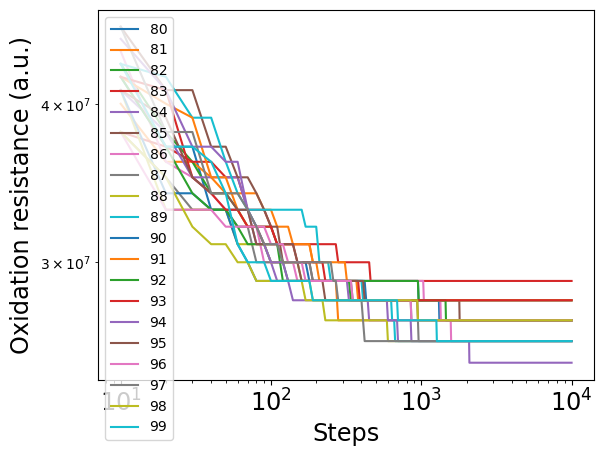

In [19]:
for i in range(80,100):
    N=31;N_alloys = N; beta = 1
    filename = "%0.2f-N%d-opt-%d.sqlite" %(beta,N,i)    
    loaded_steps, lattices, energies = load_simulation_data_sqlite(db_file=filename)
    plt.plot(loaded_steps,energies, label=i)
    rand_E[i] = energies[:1000]
plt.xticks(size='xx-large')
plt.yticks(size='xx-large')
plt.xlabel('Steps',size='xx-large')
plt.ylabel('Oxidation resistance (a.u.)',size='xx-large')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()   

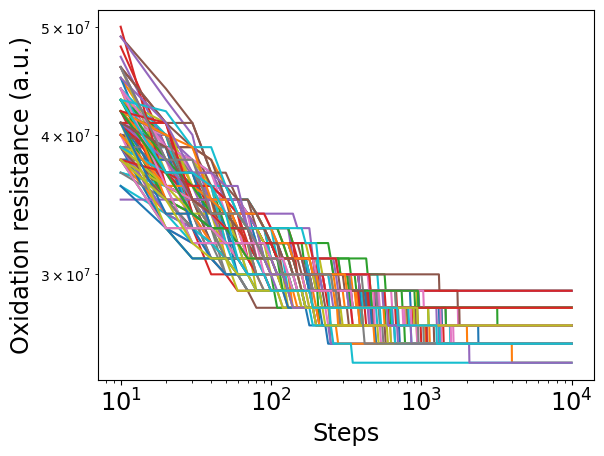

In [20]:

for i in range(runs):
    plt.plot(loaded_steps, rand_E[i],label=i)

plt.xticks(size='xx-large')
plt.yticks(size='xx-large')
plt.xlabel('Steps',size='xx-large')
plt.ylabel('Oxidation resistance (a.u.)',size='xx-large')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.show()

In [38]:
print(rand_E.shape)
print(rand_E[:,-1])
print(rand_E[:,-1].argmin(),rand_E[:,-1].min())
#print(rand_E[:,-1]<25100000)

(100, 1000)
[28000927.70600345 25001055.47372705 27001050.73792543 27000850.95851721
 28000899.43729737 27001017.43270414 26001182.65438625 26000970.51715002
 26000863.12272935 27001052.94605577 26001011.77762307 26000921.59099119
 27000921.03041828 26001056.81374663 27000975.69121887 27000934.83507346
 26000852.77226424 26001014.05293059 27001059.20369205 27000941.59571916
 26001029.07097937 27001028.41435825 27001030.63672512 27000820.2661439
 26000980.13361827 27000894.28518005 27000973.66743138 26001113.9388477
 29001038.67450235 27001008.2479416  26000887.40410695 27001094.7346926
 29000848.96723343 26000908.25363339 29000820.99555669 27000985.16411768
 26001007.92057417 26001093.6474653  27001034.94310588 26001094.68910294
 28000813.65119709 28000853.33729715 26001024.84275722 26001058.42576249
 26001081.02359264 26000960.84077624 27000921.11379498 26001057.22727049
 26000931.95834234 26000972.54463122 28000881.46325216 26001022.60257073
 28000881.06867624 27000878.21974805 28000

In [43]:
print(rand_E[:,-1][rand_E[:,-1]<26000000])
np.where(rand_E[:,-1] < 26000000)[0]

[25001055.47372705 25001113.4146098  25001129.90336914]


array([ 1, 79, 84])

In [44]:
filename = "%0.2f-N%d-opt-%d.sqlite" %(beta,N,1)    
loaded_steps, lattices, energies = load_simulation_data_sqlite(db_file=filename)

25001055.47372705


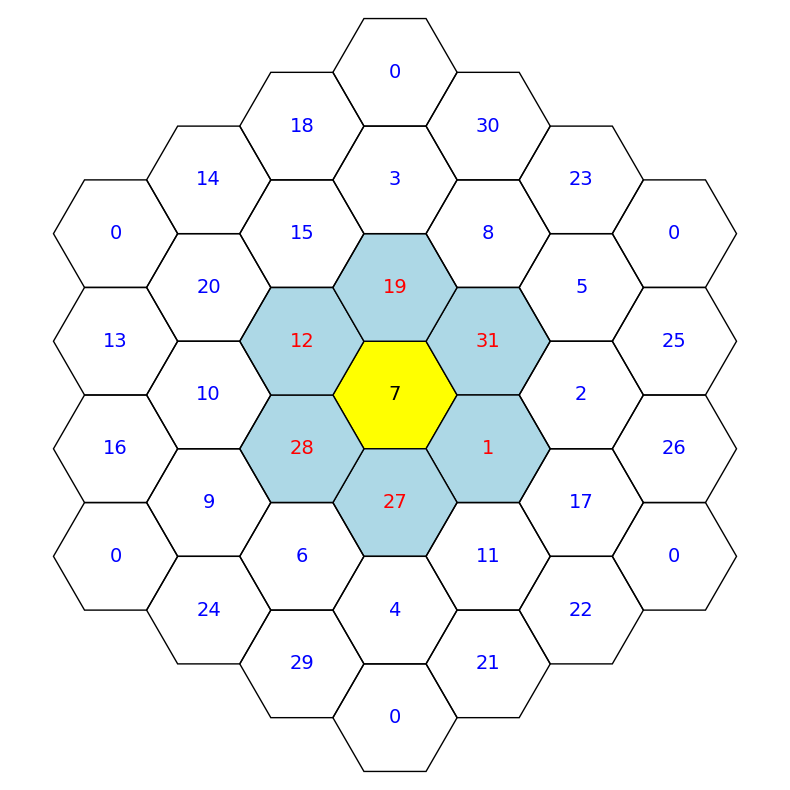

In [50]:
print(energies[-1])
plot_hexagonal_grid_with_neighbors(lattices[-1],3,0,0)

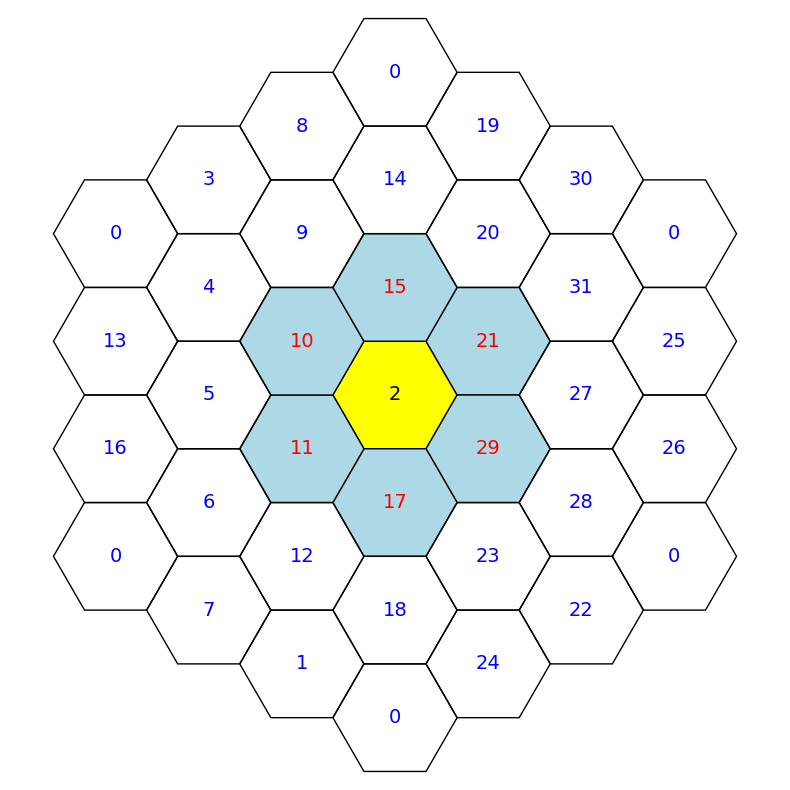

In [51]:
N=31;N_alloys = N; beta = 1
lattice,radius = initialize_lattice(N, N_alloys)
lattice = custom_init(lattice)
plot_hexagonal_grid_with_neighbors(lattice,3,0,0)
calculate_energy